In [114]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [115]:
from _chain import Chain

### Define Binary HMM 

In [116]:
def f(x1, x2):
    return np.exp((x1 - 0.5) * (x2 - 0.5))

In [117]:
phi = psi = f

In [118]:
T = 50 # chain length

In [119]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [120]:
possible_values = [0, 1]

In [112]:
N = 10000

In [121]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 29.7 s, sys: 99.2 ms, total: 29.8 s
Wall time: 29.8 s


In [122]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

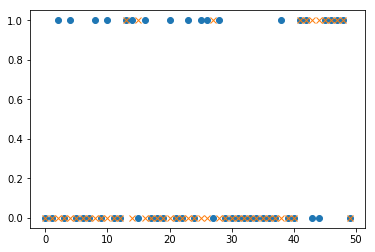

In [126]:
plot(X_dataset[0], 'o')
plot(y_dataset[0], 'x')

### Train Dummy Model (predicts y = x)

#### Evaluate 

In [191]:
y_pred = X_test

In [192]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     54172
           1       0.68      0.74      0.71     45828

   micro avg       0.72      0.72      0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



### Train CRF

In [127]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [128]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [129]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [132]:
import pycrfsuite

In [133]:
trainer = pycrfsuite.Trainer(verbose=True)

In [134]:
# Submit training data to the trainer
trainer.clear()
    
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [135]:
rm crf.model

In [136]:
# the model will be saved under 'crf.model'
trainer.train('crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 8
Seconds required: 0.026

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 165296.648685
Feature norm: 1.000000
Error norm: 96141.038952
Active features: 8
Line search trials: 1
Line search step: 0.000006
Seconds required for this iteration: 0.074

***** Iteration #2 *****
Loss: 138005.009683
Feature norm: 1.508352
Error norm: 83560.637192
Active features: 8
Line search trials: 2
Line search step: 0.466782
Seconds required for this iteration: 0.065

***** Iteration #3 *****
Loss: 122751.570660
Feature norm: 1.954836
Error norm: 16013.483060
Active features: 8
Line search trials: 1
Line search step: 1.000000
Seconds required for this 

####  Evaluate

In [139]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')

y_pred = [tagger.tag(xseq) for xseq in X_test]

In [142]:
from sklearn.metrics import classification_report

# Create a mapping of labels to indices
labels = {"0": 0, "1": 1}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90     54359
           1       0.93      0.82      0.87     45641

   micro avg       0.89      0.89      0.89    100000
   macro avg       0.90      0.89      0.89    100000
weighted avg       0.89      0.89      0.89    100000



### Training FC NN 

#### Define 

In [99]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [204]:
n_epochs = 1000
batch_size, D_in, D_hidden, D_out = 64, T, 2 * T, T

In [205]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Sigmoid()
        )

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [206]:
from torch.utils.data import Dataset

class ChainDataset(Dataset):
    
    def __init__(self, X, y, flatten=True):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        sample = {
            'X': torch.from_numpy(self._X[idx]).float(),
            'y': torch.from_numpy(self._y[idx]).float()  
        }
        return sample

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

In [208]:
trainset = ChainDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#### Train 

In [210]:
model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        model.zero_grad()
        
        y_pred = model(X_batch)
        loss = F.binary_cross_entropy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('epoch {}:: loss = {}'. format(epoch, loss))
        learning_curve.append(loss)

epoch 10:: loss = 0.1794310361146927
epoch 20:: loss = 0.17586089670658112
epoch 30:: loss = 0.16139812767505646
epoch 40:: loss = 0.18992595374584198
epoch 50:: loss = 0.19035489857196808
epoch 60:: loss = 0.193160280585289
epoch 70:: loss = 0.17831426858901978
epoch 80:: loss = 0.1664971113204956
epoch 90:: loss = 0.18053899705410004
epoch 100:: loss = 0.1778762936592102
epoch 110:: loss = 0.17553579807281494
epoch 120:: loss = 0.20185601711273193
epoch 130:: loss = 0.16259843111038208
epoch 140:: loss = 0.18365336954593658
epoch 150:: loss = 0.1703641563653946
epoch 160:: loss = 0.19524164497852325
epoch 170:: loss = 0.19776782393455505
epoch 180:: loss = 0.15394914150238037
epoch 190:: loss = 0.1710844784975052
epoch 200:: loss = 0.17350906133651733
epoch 210:: loss = 0.16375832259655
epoch 220:: loss = 0.1761559247970581
epoch 230:: loss = 0.16988307237625122
epoch 240:: loss = 0.1756851226091385
epoch 250:: loss = 0.1656629741191864
epoch 260:: loss = 0.1846892535686493
epoch 270

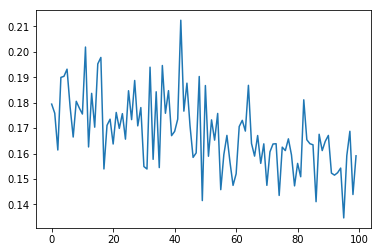

In [211]:
plot(learning_curvening_curve);

#### Evaluate 

In [212]:
model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
)

In [213]:
y_pred = np.array([model(torch.from_numpy(xseq).float()).detach().numpy() for xseq in X_test])

In [214]:
y_pred = 1 * (y_pred > 0.5)

In [215]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     54133
           1       0.90      0.92      0.91     45867

   micro avg       0.92      0.92      0.92    100000
   macro avg       0.92      0.92      0.92    100000
weighted avg       0.92      0.92      0.92    100000

